# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [188]:
# run this once to unzip the file
# ! yes | unzip processed-celeba-small.zip

In [189]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms as T
from torch.utils.tensorboard import SummaryWriter

import tests

In [190]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [191]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]),
    ]
    
    return T.Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [192]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        self.transforms = transforms
        self.img_files = glob(directory + '*' + extension)

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.img_files)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        image = Image.open(self.img_files[index])
        tensor = self.transforms(image) 
        return tensor

In [193]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

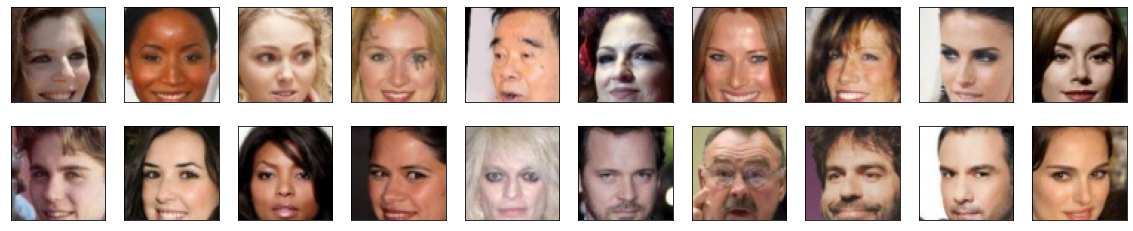

In [194]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [195]:
from torch.nn import Module
from torch import nn

In [196]:
class ConvBlock(nn.Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, batch_norm: bool = True):
        super(ConvBlock, self).__init__()
        ####
        # IMPLEMENT HERE
        ####
        self.batch_norm = batch_norm
        if batch_norm:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
            self.bn = nn.BatchNorm2d(out_channels)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=True)
            
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ####
        # IMPLEMENT HERE
        ####
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x
        

class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
        conv_dim = 32
        self.cb1 = ConvBlock(3, conv_dim, 4, False)  # (3, 64, 64) -> (32, 32, 32)
        self.cb2 = ConvBlock(conv_dim, 2 * conv_dim, 4, True)  # (32, 32, 32) -> (64, 16, 16)
        self.cb3 = ConvBlock(2 * conv_dim, 4 * conv_dim, 4, True)  # (64, 16, 16) -> (128, 8, 8)
        self.cb4 = ConvBlock(4 * conv_dim, 8 * conv_dim, 4, True)  # (128, 8, 8) -> (256, 4, 4)
        self.cb5 = ConvBlock(8 * conv_dim, 16 * conv_dim, 4, True)  # (256, 4, 4) -> (512, 2, 2)
        self.cb6 = ConvBlock(16 * conv_dim, 1, 4, False)  # (512, 2, 2) -> (1, 1, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.cb1(x)
        x = self.cb2(x)
        x = self.cb3(x)
        x = self.cb4(x)
        x = self.cb5(x)
        x = self.cb6(x)
        return x

In [197]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


In [198]:
class DeconvBlock(nn.Module):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 batch_norm: bool = True):
        super(DeconvBlock, self).__init__()
        ####
        # IMPLEMENT HERE
        ####
        self.batch_norm = batch_norm
        
        if batch_norm:
            self.convt = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
            self.bn = nn.BatchNorm2d(out_channels)
        else:
            self.convt = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=True)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ####
        # IMPLEMENT HERE
        ####
        x = self.convt(x)
        if self.batch_norm:
            x = self.bn(x)
        x = nn.functional.relu(x)
        return x

class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        # TODO: instantiate the different layers
        conv_dim = 16
        self.deconv1 = DeconvBlock(latent_dim, 8 * conv_dim, 4, 2, 0, True)  # (1, 1) -> (4, 4)
        self.deconv2 = DeconvBlock(8 * conv_dim, 4 * conv_dim, 4, 2, 1, True)  # (4, 4) -> (8, 8)
        self.deconv3 = DeconvBlock(4 * conv_dim, 2 * conv_dim, 4, 2, 1, True)  # (8, 8) -> (16, 16)
        self.deconv4 = DeconvBlock(2 * conv_dim, conv_dim, 4, 2, 1, True)  # (16, 16) -> (32, 32)
        self.deconv5 = nn.ConvTranspose2d(conv_dim, 3, 4, 2, 1)  # (32, 32) -> (64, 64)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        x = torch.tanh(x)
        return x

In [199]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [200]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    lr = 2e-4
    beta1 = 0.5
    beta2 = beta1**2

    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [201]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss 
    smooth = False
    batch_size = fake_logits.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size).cuda() * 0.9
    else:
        labels = torch.ones(batch_size).cuda()  # real labels = 1
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(fake_logits.squeeze(), labels)
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [202]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss
    # Compute the discriminator loss on real, training images
    real_loss = generator_loss(real_logits)

    # Compute the discriminator loss on fake, generated images
    batch_size = fake_logits.size(0)
    labels = torch.zeros(batch_size).cuda()  # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    fake_loss = criterion(fake_logits.squeeze(), labels)
    
    loss = real_loss + fake_loss
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [203]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    # sample a random point between both distributions
    alpha = torch.rand(real_samples.shape).cuda()
    x_hat = alpha * real_samples + (1 - alpha) * fake_samples

    # calculate the gradient
    # x_hat.requires_grad = True
    pred = discriminator(x_hat)
    grad = torch.autograd.grad(pred, x_hat, grad_outputs=torch.ones_like(pred), create_graph=True)[0]

    # calculate the norm and the final penalty
    norm = torch.norm(grad.view(-1), 2)
    gp = ((norm - 1)**2).mean()
    
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [204]:
def generator_step(generator: Generator, discriminator: Discriminator, g_optimizer: torch.optim.Optimizer, 
                   batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    g_optimizer.zero_grad()

    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    if torch.cuda.is_available():
        z = z.cuda()
    fake_images = generator(z)

    # Compute the discriminator losses on fake images 
    # using flipped labels!
    D_fake = discriminator(fake_images)
    g_loss = generator_loss(D_fake)

    # perform backprop
    g_loss.backward()
    g_optimizer.step()

    return {'loss': g_loss}


def discriminator_step(discriminator: Discriminator, d_optimizer: torch.optim.Optimizer, 
                       batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    d_optimizer.zero_grad()

    # Compute the discriminator results on real images 
    if torch.cuda.is_available():
        real_images = real_images.cuda()
        
    D_real = discriminator(real_images)

    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()

    # move x to GPU, if available
    if torch.cuda.is_available():
        z = z.cuda()
    fake_images = generator(z)

    # Compute the discriminator losses on fake images            
    D_fake = discriminator(fake_images.detach())

    # Compute loss loss and perform backprop
    d_loss = discriminator_loss(D_real, D_fake)
    d_loss.backward()
    d_optimizer.step()

    gp = gradient_penalty(discriminator, real_images, fake_images)
    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [205]:
from datetime import datetime

In [206]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 20

# number of images in each batch
batch_size = 64

In [207]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [208]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2023-02-12 12:52:25 | Epoch [1/20] | Batch 0/509 | d_loss: 1.3887 | g_loss: 0.7831
2023-02-12 12:52:27 | Epoch [1/20] | Batch 50/509 | d_loss: 0.0291 | g_loss: 3.6057
2023-02-12 12:52:28 | Epoch [1/20] | Batch 100/509 | d_loss: 0.0023 | g_loss: 6.1447
2023-02-12 12:52:30 | Epoch [1/20] | Batch 150/509 | d_loss: 0.0127 | g_loss: 8.2239
2023-02-12 12:52:32 | Epoch [1/20] | Batch 200/509 | d_loss: 0.0001 | g_loss: 10.0122
2023-02-12 12:52:33 | Epoch [1/20] | Batch 250/509 | d_loss: 0.0000 | g_loss: 12.5105
2023-02-12 12:52:35 | Epoch [1/20] | Batch 300/509 | d_loss: 0.0000 | g_loss: 14.0752
2023-02-12 12:52:36 | Epoch [1/20] | Batch 350/509 | d_loss: 0.0000 | g_loss: 14.4163
2023-02-12 12:52:38 | Epoch [1/20] | Batch 400/509 | d_loss: 0.0000 | g_loss: 15.0115
2023-02-12 12:52:39 | Epoch [1/20] | Batch 450/509 | d_loss: 0.0000 | g_loss: 14.9629
2023-02-12 12:52:41 | Epoch [1/20] | Batch 500/509 | d_loss: 0.0000 | g_loss: 10.8811


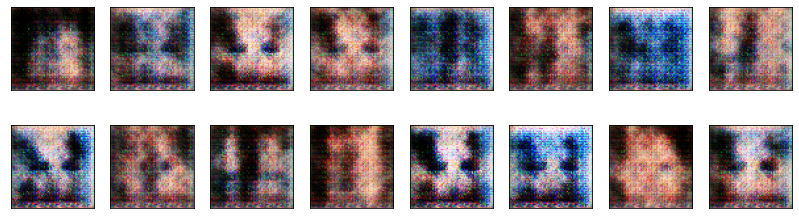

2023-02-12 12:52:42 | Epoch [2/20] | Batch 0/509 | d_loss: 0.0003 | g_loss: 8.3966
2023-02-12 12:52:44 | Epoch [2/20] | Batch 50/509 | d_loss: 0.0122 | g_loss: 8.9520
2023-02-12 12:52:45 | Epoch [2/20] | Batch 100/509 | d_loss: 0.0778 | g_loss: 9.1758
2023-02-12 12:52:47 | Epoch [2/20] | Batch 150/509 | d_loss: 0.0000 | g_loss: 15.7135
2023-02-12 12:52:48 | Epoch [2/20] | Batch 200/509 | d_loss: 0.0001 | g_loss: 12.5589
2023-02-12 12:52:50 | Epoch [2/20] | Batch 250/509 | d_loss: 0.0006 | g_loss: 12.4250
2023-02-12 12:52:51 | Epoch [2/20] | Batch 300/509 | d_loss: 0.0002 | g_loss: 12.3809
2023-02-12 12:52:53 | Epoch [2/20] | Batch 350/509 | d_loss: 0.0002 | g_loss: 12.8026
2023-02-12 12:52:55 | Epoch [2/20] | Batch 400/509 | d_loss: 0.0006 | g_loss: 10.7307
2023-02-12 12:52:56 | Epoch [2/20] | Batch 450/509 | d_loss: 0.0012 | g_loss: 11.6161
2023-02-12 12:52:58 | Epoch [2/20] | Batch 500/509 | d_loss: 1.0165 | g_loss: 12.3614


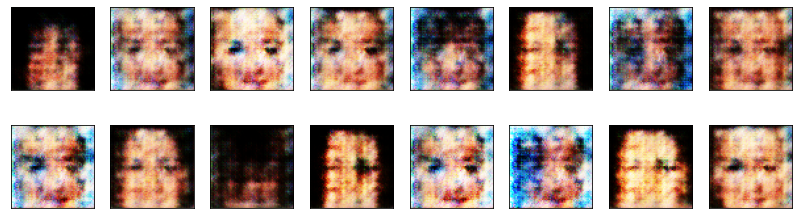

2023-02-12 12:52:59 | Epoch [3/20] | Batch 0/509 | d_loss: 0.0000 | g_loss: 8.3417
2023-02-12 12:53:00 | Epoch [3/20] | Batch 50/509 | d_loss: 0.0001 | g_loss: 10.4907
2023-02-12 12:53:02 | Epoch [3/20] | Batch 100/509 | d_loss: 0.0032 | g_loss: 7.3205
2023-02-12 12:53:04 | Epoch [3/20] | Batch 150/509 | d_loss: 0.0000 | g_loss: 10.8043
2023-02-12 12:53:05 | Epoch [3/20] | Batch 200/509 | d_loss: 0.0000 | g_loss: 16.4213
2023-02-12 12:53:07 | Epoch [3/20] | Batch 250/509 | d_loss: 0.0090 | g_loss: 12.2182
2023-02-12 12:53:08 | Epoch [3/20] | Batch 300/509 | d_loss: 0.0000 | g_loss: 17.1462
2023-02-12 12:53:10 | Epoch [3/20] | Batch 350/509 | d_loss: 0.0004 | g_loss: 12.5107
2023-02-12 12:53:12 | Epoch [3/20] | Batch 400/509 | d_loss: 0.0010 | g_loss: 10.4686
2023-02-12 12:53:13 | Epoch [3/20] | Batch 450/509 | d_loss: 0.3690 | g_loss: 9.9917
2023-02-12 12:53:15 | Epoch [3/20] | Batch 500/509 | d_loss: 0.0194 | g_loss: 10.1212


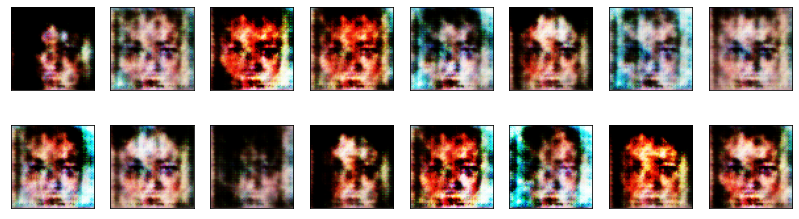

2023-02-12 12:53:16 | Epoch [4/20] | Batch 0/509 | d_loss: 0.1695 | g_loss: 11.1721
2023-02-12 12:53:17 | Epoch [4/20] | Batch 50/509 | d_loss: 0.0000 | g_loss: 10.3246
2023-02-12 12:53:19 | Epoch [4/20] | Batch 100/509 | d_loss: 0.0000 | g_loss: 16.8779
2023-02-12 12:53:20 | Epoch [4/20] | Batch 150/509 | d_loss: 0.0066 | g_loss: 5.9441
2023-02-12 12:53:22 | Epoch [4/20] | Batch 200/509 | d_loss: 0.0008 | g_loss: 11.2906
2023-02-12 12:53:23 | Epoch [4/20] | Batch 250/509 | d_loss: 0.0061 | g_loss: 10.8908
2023-02-12 12:53:25 | Epoch [4/20] | Batch 300/509 | d_loss: 0.0478 | g_loss: 9.1250
2023-02-12 12:53:26 | Epoch [4/20] | Batch 350/509 | d_loss: 0.0154 | g_loss: 10.6890
2023-02-12 12:53:28 | Epoch [4/20] | Batch 400/509 | d_loss: 0.0000 | g_loss: 19.3050
2023-02-12 12:53:30 | Epoch [4/20] | Batch 450/509 | d_loss: 0.0003 | g_loss: 12.9547
2023-02-12 12:53:31 | Epoch [4/20] | Batch 500/509 | d_loss: 0.0166 | g_loss: 11.2089


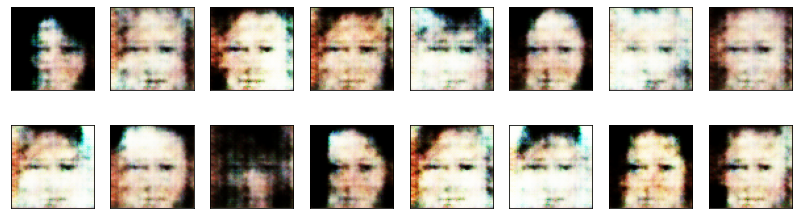

2023-02-12 12:53:32 | Epoch [5/20] | Batch 0/509 | d_loss: 0.1089 | g_loss: 11.6959
2023-02-12 12:53:34 | Epoch [5/20] | Batch 50/509 | d_loss: 0.0000 | g_loss: 8.8285
2023-02-12 12:53:36 | Epoch [5/20] | Batch 100/509 | d_loss: 0.0228 | g_loss: 16.5459
2023-02-12 12:53:37 | Epoch [5/20] | Batch 150/509 | d_loss: 0.0003 | g_loss: 1.7074
2023-02-12 12:53:39 | Epoch [5/20] | Batch 200/509 | d_loss: 0.0000 | g_loss: 15.2372
2023-02-12 12:53:40 | Epoch [5/20] | Batch 250/509 | d_loss: 0.0012 | g_loss: 13.5583
2023-02-12 12:53:42 | Epoch [5/20] | Batch 300/509 | d_loss: 0.0004 | g_loss: 13.1894
2023-02-12 12:53:44 | Epoch [5/20] | Batch 350/509 | d_loss: 0.0508 | g_loss: 16.9069
2023-02-12 12:53:45 | Epoch [5/20] | Batch 400/509 | d_loss: 0.0894 | g_loss: 9.0995
2023-02-12 12:53:47 | Epoch [5/20] | Batch 450/509 | d_loss: 2.1995 | g_loss: 6.2690
2023-02-12 12:53:48 | Epoch [5/20] | Batch 500/509 | d_loss: 0.0015 | g_loss: 8.3471


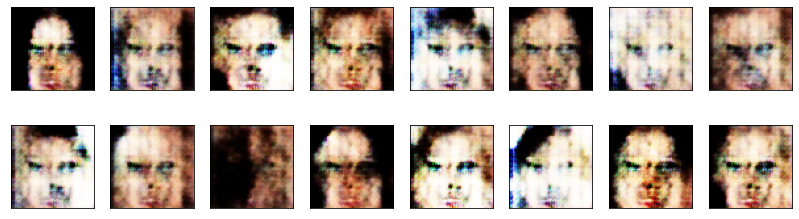

2023-02-12 12:53:49 | Epoch [6/20] | Batch 0/509 | d_loss: 0.0001 | g_loss: 16.2742
2023-02-12 12:53:51 | Epoch [6/20] | Batch 50/509 | d_loss: 0.0055 | g_loss: 3.9494
2023-02-12 12:53:52 | Epoch [6/20] | Batch 100/509 | d_loss: 0.0001 | g_loss: 15.3818
2023-02-12 12:53:54 | Epoch [6/20] | Batch 150/509 | d_loss: 0.0001 | g_loss: 14.9939
2023-02-12 12:53:56 | Epoch [6/20] | Batch 200/509 | d_loss: 0.0644 | g_loss: 9.0822
2023-02-12 12:53:57 | Epoch [6/20] | Batch 250/509 | d_loss: 0.0000 | g_loss: 14.5143
2023-02-12 12:53:59 | Epoch [6/20] | Batch 300/509 | d_loss: 0.0124 | g_loss: 10.1337
2023-02-12 12:54:00 | Epoch [6/20] | Batch 350/509 | d_loss: 0.0450 | g_loss: 12.3291
2023-02-12 12:54:02 | Epoch [6/20] | Batch 400/509 | d_loss: 0.0007 | g_loss: 12.1260
2023-02-12 12:54:04 | Epoch [6/20] | Batch 450/509 | d_loss: 0.0270 | g_loss: 13.3081
2023-02-12 12:54:05 | Epoch [6/20] | Batch 500/509 | d_loss: 0.4705 | g_loss: 9.8537


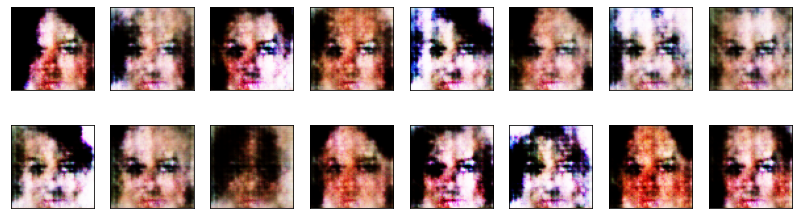

2023-02-12 12:54:06 | Epoch [7/20] | Batch 0/509 | d_loss: 0.0007 | g_loss: 9.8842
2023-02-12 12:54:08 | Epoch [7/20] | Batch 50/509 | d_loss: 0.0008 | g_loss: 12.4242
2023-02-12 12:54:10 | Epoch [7/20] | Batch 100/509 | d_loss: 0.0050 | g_loss: 11.6705
2023-02-12 12:54:11 | Epoch [7/20] | Batch 150/509 | d_loss: 0.0000 | g_loss: 16.0195
2023-02-12 12:54:13 | Epoch [7/20] | Batch 200/509 | d_loss: 0.0027 | g_loss: 13.0500
2023-02-12 12:54:14 | Epoch [7/20] | Batch 250/509 | d_loss: 0.0157 | g_loss: 13.3290
2023-02-12 12:54:16 | Epoch [7/20] | Batch 300/509 | d_loss: 2.0578 | g_loss: 10.5047
2023-02-12 12:54:17 | Epoch [7/20] | Batch 350/509 | d_loss: 0.1769 | g_loss: 9.4284
2023-02-12 12:54:19 | Epoch [7/20] | Batch 400/509 | d_loss: 0.0000 | g_loss: 15.5150
2023-02-12 12:54:21 | Epoch [7/20] | Batch 450/509 | d_loss: 0.0000 | g_loss: 16.6337
2023-02-12 12:54:22 | Epoch [7/20] | Batch 500/509 | d_loss: 0.0049 | g_loss: 13.5366


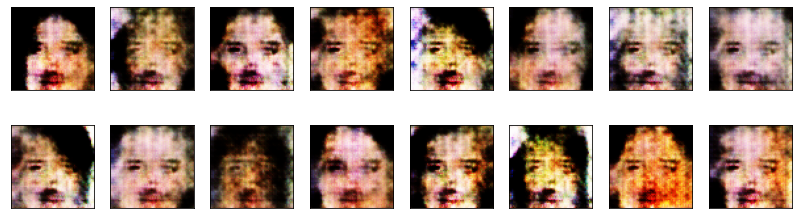

2023-02-12 12:54:23 | Epoch [8/20] | Batch 0/509 | d_loss: 0.3026 | g_loss: 7.7162
2023-02-12 12:54:25 | Epoch [8/20] | Batch 50/509 | d_loss: 0.0000 | g_loss: 16.2182
2023-02-12 12:54:27 | Epoch [8/20] | Batch 100/509 | d_loss: 0.0007 | g_loss: 13.2955
2023-02-12 12:54:28 | Epoch [8/20] | Batch 150/509 | d_loss: 0.2769 | g_loss: 8.1275
2023-02-12 12:54:30 | Epoch [8/20] | Batch 200/509 | d_loss: 0.0003 | g_loss: 8.5347
2023-02-12 12:54:31 | Epoch [8/20] | Batch 250/509 | d_loss: 0.0514 | g_loss: 6.8742
2023-02-12 12:54:33 | Epoch [8/20] | Batch 300/509 | d_loss: 0.0001 | g_loss: 7.6979
2023-02-12 12:54:35 | Epoch [8/20] | Batch 350/509 | d_loss: 0.1279 | g_loss: 8.8086
2023-02-12 12:54:36 | Epoch [8/20] | Batch 400/509 | d_loss: 0.0003 | g_loss: 13.9492
2023-02-12 12:54:38 | Epoch [8/20] | Batch 450/509 | d_loss: 0.0018 | g_loss: 11.4543
2023-02-12 12:54:39 | Epoch [8/20] | Batch 500/509 | d_loss: 0.0000 | g_loss: 16.1840


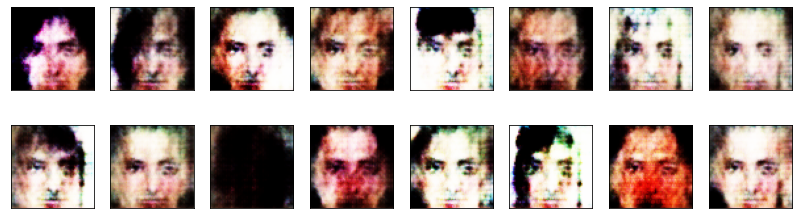

2023-02-12 12:54:40 | Epoch [9/20] | Batch 0/509 | d_loss: 0.0081 | g_loss: 11.0792
2023-02-12 12:54:42 | Epoch [9/20] | Batch 50/509 | d_loss: 0.0097 | g_loss: 12.3974
2023-02-12 12:54:44 | Epoch [9/20] | Batch 100/509 | d_loss: 0.0203 | g_loss: 12.9778
2023-02-12 12:54:45 | Epoch [9/20] | Batch 150/509 | d_loss: 0.0022 | g_loss: 14.0039
2023-02-12 12:54:47 | Epoch [9/20] | Batch 200/509 | d_loss: 0.0000 | g_loss: 12.6301
2023-02-12 12:54:48 | Epoch [9/20] | Batch 250/509 | d_loss: 1.7932 | g_loss: 9.9659
2023-02-12 12:54:50 | Epoch [9/20] | Batch 300/509 | d_loss: 0.0010 | g_loss: 4.3642
2023-02-12 12:54:52 | Epoch [9/20] | Batch 350/509 | d_loss: 0.0816 | g_loss: 8.7210
2023-02-12 12:54:53 | Epoch [9/20] | Batch 400/509 | d_loss: 0.1128 | g_loss: 10.9553
2023-02-12 12:54:55 | Epoch [9/20] | Batch 450/509 | d_loss: 0.0019 | g_loss: 12.0781
2023-02-12 12:54:56 | Epoch [9/20] | Batch 500/509 | d_loss: 0.0018 | g_loss: 6.4211


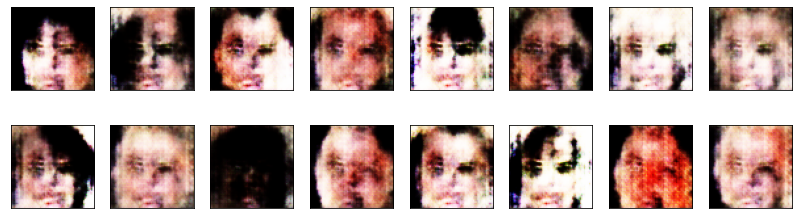

2023-02-12 12:54:57 | Epoch [10/20] | Batch 0/509 | d_loss: 0.0033 | g_loss: 8.7089
2023-02-12 12:54:59 | Epoch [10/20] | Batch 50/509 | d_loss: 0.0299 | g_loss: 2.8572
2023-02-12 12:55:01 | Epoch [10/20] | Batch 100/509 | d_loss: 0.0033 | g_loss: 13.7892
2023-02-12 12:55:02 | Epoch [10/20] | Batch 150/509 | d_loss: 0.0377 | g_loss: 12.0521
2023-02-12 12:55:04 | Epoch [10/20] | Batch 200/509 | d_loss: 0.0133 | g_loss: 4.9863
2023-02-12 12:55:05 | Epoch [10/20] | Batch 250/509 | d_loss: 0.0001 | g_loss: 13.3729
2023-02-12 12:55:07 | Epoch [10/20] | Batch 300/509 | d_loss: 0.0177 | g_loss: 13.2215
2023-02-12 12:55:09 | Epoch [10/20] | Batch 350/509 | d_loss: 0.0005 | g_loss: 5.4699
2023-02-12 12:55:10 | Epoch [10/20] | Batch 400/509 | d_loss: 0.1307 | g_loss: 7.8985
2023-02-12 12:55:12 | Epoch [10/20] | Batch 450/509 | d_loss: 0.0198 | g_loss: 9.6756
2023-02-12 12:55:13 | Epoch [10/20] | Batch 500/509 | d_loss: 0.0000 | g_loss: 18.4445


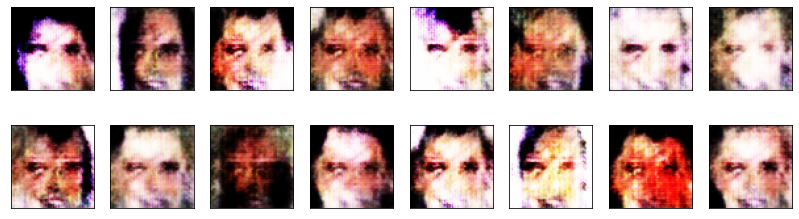

2023-02-12 12:55:14 | Epoch [11/20] | Batch 0/509 | d_loss: 0.0150 | g_loss: 11.7992
2023-02-12 12:55:16 | Epoch [11/20] | Batch 50/509 | d_loss: 0.0193 | g_loss: 10.3346
2023-02-12 12:55:17 | Epoch [11/20] | Batch 100/509 | d_loss: 0.0000 | g_loss: 12.8769
2023-02-12 12:55:19 | Epoch [11/20] | Batch 150/509 | d_loss: 0.0004 | g_loss: 13.1995
2023-02-12 12:55:21 | Epoch [11/20] | Batch 200/509 | d_loss: 0.3974 | g_loss: 12.0579
2023-02-12 12:55:22 | Epoch [11/20] | Batch 250/509 | d_loss: 0.0001 | g_loss: 10.4111
2023-02-12 12:55:24 | Epoch [11/20] | Batch 300/509 | d_loss: 0.0547 | g_loss: 13.3576
2023-02-12 12:55:26 | Epoch [11/20] | Batch 350/509 | d_loss: 0.0633 | g_loss: 8.5417
2023-02-12 12:55:27 | Epoch [11/20] | Batch 400/509 | d_loss: 0.0001 | g_loss: 17.1355
2023-02-12 12:55:29 | Epoch [11/20] | Batch 450/509 | d_loss: 0.0029 | g_loss: 6.0514
2023-02-12 12:55:30 | Epoch [11/20] | Batch 500/509 | d_loss: 0.0002 | g_loss: 13.4702


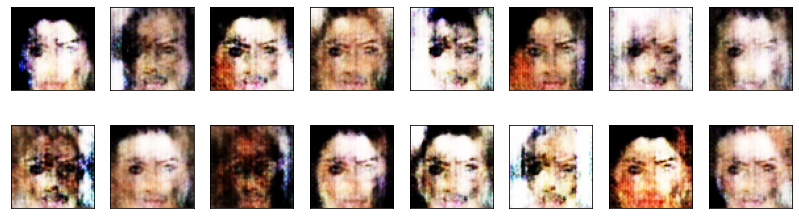

2023-02-12 12:55:31 | Epoch [12/20] | Batch 0/509 | d_loss: 0.0002 | g_loss: 9.0323
2023-02-12 12:55:33 | Epoch [12/20] | Batch 50/509 | d_loss: 0.0001 | g_loss: 9.3929
2023-02-12 12:55:35 | Epoch [12/20] | Batch 100/509 | d_loss: 0.0025 | g_loss: 7.0408
2023-02-12 12:55:36 | Epoch [12/20] | Batch 150/509 | d_loss: 0.0009 | g_loss: 11.2930
2023-02-12 12:55:38 | Epoch [12/20] | Batch 200/509 | d_loss: 0.0803 | g_loss: 8.9924
2023-02-12 12:55:39 | Epoch [12/20] | Batch 250/509 | d_loss: 0.0003 | g_loss: 13.9719
2023-02-12 12:55:41 | Epoch [12/20] | Batch 300/509 | d_loss: 0.0611 | g_loss: 14.5950
2023-02-12 12:55:43 | Epoch [12/20] | Batch 350/509 | d_loss: 0.0000 | g_loss: 16.2351
2023-02-12 12:55:44 | Epoch [12/20] | Batch 400/509 | d_loss: 0.0485 | g_loss: 11.4443
2023-02-12 12:55:46 | Epoch [12/20] | Batch 450/509 | d_loss: 0.0000 | g_loss: 10.0815
2023-02-12 12:55:48 | Epoch [12/20] | Batch 500/509 | d_loss: 0.0015 | g_loss: 14.8885


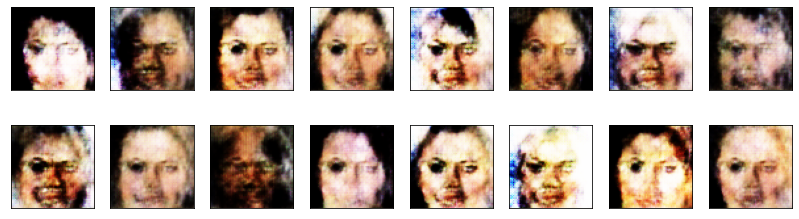

2023-02-12 12:55:49 | Epoch [13/20] | Batch 0/509 | d_loss: 0.1593 | g_loss: 9.5817
2023-02-12 12:55:50 | Epoch [13/20] | Batch 50/509 | d_loss: 0.0002 | g_loss: 14.8038
2023-02-12 12:55:52 | Epoch [13/20] | Batch 100/509 | d_loss: 0.0064 | g_loss: 11.2003
2023-02-12 12:55:53 | Epoch [13/20] | Batch 150/509 | d_loss: 0.0054 | g_loss: 4.0862
2023-02-12 12:55:55 | Epoch [13/20] | Batch 200/509 | d_loss: 0.0040 | g_loss: 10.9906
2023-02-12 12:55:57 | Epoch [13/20] | Batch 250/509 | d_loss: 0.5378 | g_loss: 8.9527
2023-02-12 12:55:58 | Epoch [13/20] | Batch 300/509 | d_loss: 0.0000 | g_loss: 17.9008
2023-02-12 12:56:00 | Epoch [13/20] | Batch 350/509 | d_loss: 0.0146 | g_loss: 7.9893
2023-02-12 12:56:01 | Epoch [13/20] | Batch 400/509 | d_loss: 0.0533 | g_loss: 11.7279
2023-02-12 12:56:03 | Epoch [13/20] | Batch 450/509 | d_loss: 0.0041 | g_loss: 10.1850
2023-02-12 12:56:05 | Epoch [13/20] | Batch 500/509 | d_loss: 0.0139 | g_loss: 7.9799


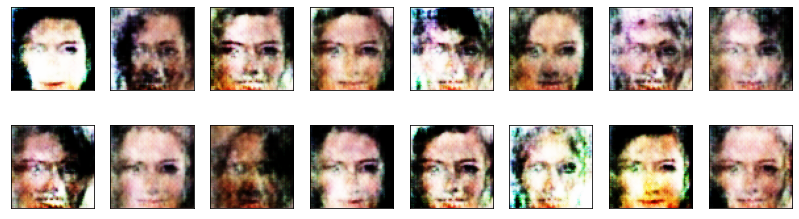

2023-02-12 12:56:06 | Epoch [14/20] | Batch 0/509 | d_loss: 0.0001 | g_loss: 15.7543
2023-02-12 12:56:07 | Epoch [14/20] | Batch 50/509 | d_loss: 0.2534 | g_loss: 10.9920
2023-02-12 12:56:09 | Epoch [14/20] | Batch 100/509 | d_loss: 0.0083 | g_loss: 12.0338
2023-02-12 12:56:11 | Epoch [14/20] | Batch 150/509 | d_loss: 0.0004 | g_loss: 13.6309
2023-02-12 12:56:12 | Epoch [14/20] | Batch 200/509 | d_loss: 0.0019 | g_loss: 5.6861
2023-02-12 12:56:14 | Epoch [14/20] | Batch 250/509 | d_loss: 0.1472 | g_loss: 15.4051
2023-02-12 12:56:16 | Epoch [14/20] | Batch 300/509 | d_loss: 0.0001 | g_loss: 15.8684
2023-02-12 12:56:17 | Epoch [14/20] | Batch 350/509 | d_loss: 0.0229 | g_loss: 8.1423
2023-02-12 12:56:19 | Epoch [14/20] | Batch 400/509 | d_loss: 0.5085 | g_loss: 15.7640
2023-02-12 12:56:20 | Epoch [14/20] | Batch 450/509 | d_loss: 2.2578 | g_loss: 7.2857
2023-02-12 12:56:22 | Epoch [14/20] | Batch 500/509 | d_loss: 0.0478 | g_loss: 11.2683


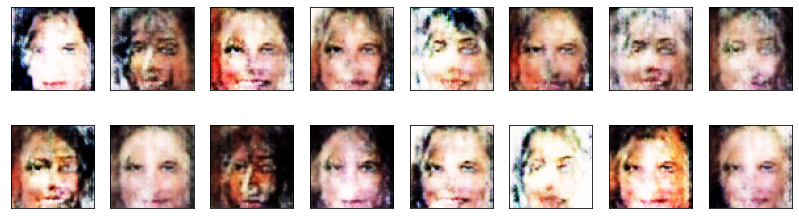

2023-02-12 12:56:23 | Epoch [15/20] | Batch 0/509 | d_loss: 0.0001 | g_loss: 17.0782
2023-02-12 12:56:25 | Epoch [15/20] | Batch 50/509 | d_loss: 0.0027 | g_loss: 5.1817
2023-02-12 12:56:26 | Epoch [15/20] | Batch 100/509 | d_loss: 0.0014 | g_loss: 14.7635
2023-02-12 12:56:28 | Epoch [15/20] | Batch 150/509 | d_loss: 0.0018 | g_loss: 11.2608
2023-02-12 12:56:29 | Epoch [15/20] | Batch 200/509 | d_loss: 0.0242 | g_loss: 9.8265
2023-02-12 12:56:31 | Epoch [15/20] | Batch 250/509 | d_loss: 0.0030 | g_loss: 8.0988
2023-02-12 12:56:33 | Epoch [15/20] | Batch 300/509 | d_loss: 0.0193 | g_loss: 7.7987
2023-02-12 12:56:34 | Epoch [15/20] | Batch 350/509 | d_loss: 0.0012 | g_loss: 12.9181
2023-02-12 12:56:36 | Epoch [15/20] | Batch 400/509 | d_loss: 0.0065 | g_loss: 10.4836
2023-02-12 12:56:38 | Epoch [15/20] | Batch 450/509 | d_loss: 0.0370 | g_loss: 8.1505
2023-02-12 12:56:39 | Epoch [15/20] | Batch 500/509 | d_loss: 0.0001 | g_loss: 17.2292


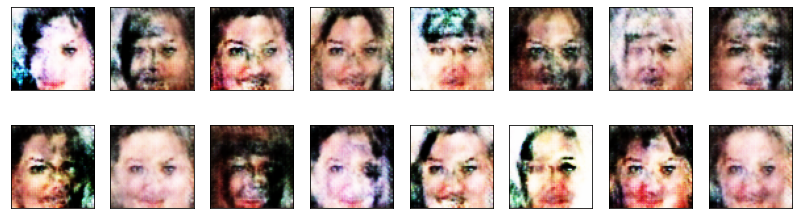

2023-02-12 12:56:40 | Epoch [16/20] | Batch 0/509 | d_loss: 0.0077 | g_loss: 7.8799
2023-02-12 12:56:42 | Epoch [16/20] | Batch 50/509 | d_loss: 0.0181 | g_loss: 16.9520
2023-02-12 12:56:44 | Epoch [16/20] | Batch 100/509 | d_loss: 0.0000 | g_loss: 11.3411
2023-02-12 12:56:45 | Epoch [16/20] | Batch 150/509 | d_loss: 0.0000 | g_loss: 18.1992
2023-02-12 12:56:47 | Epoch [16/20] | Batch 200/509 | d_loss: 0.0002 | g_loss: 6.8706
2023-02-12 12:56:49 | Epoch [16/20] | Batch 250/509 | d_loss: 0.0000 | g_loss: 14.6230
2023-02-12 12:56:50 | Epoch [16/20] | Batch 300/509 | d_loss: 0.0421 | g_loss: 3.3664
2023-02-12 12:56:52 | Epoch [16/20] | Batch 350/509 | d_loss: 0.0143 | g_loss: 16.0711
2023-02-12 12:56:53 | Epoch [16/20] | Batch 400/509 | d_loss: 0.4387 | g_loss: 12.7918
2023-02-12 12:56:55 | Epoch [16/20] | Batch 450/509 | d_loss: 0.0183 | g_loss: 5.2390
2023-02-12 12:56:56 | Epoch [16/20] | Batch 500/509 | d_loss: 0.0003 | g_loss: 15.2872


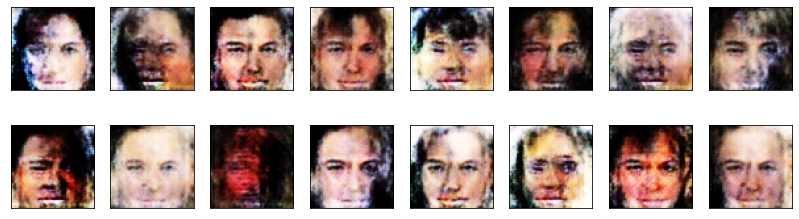

2023-02-12 12:56:58 | Epoch [17/20] | Batch 0/509 | d_loss: 0.0026 | g_loss: 17.5641
2023-02-12 12:56:59 | Epoch [17/20] | Batch 50/509 | d_loss: 0.0102 | g_loss: 11.4177
2023-02-12 12:57:01 | Epoch [17/20] | Batch 100/509 | d_loss: 0.0000 | g_loss: 18.4461
2023-02-12 12:57:02 | Epoch [17/20] | Batch 150/509 | d_loss: 1.0137 | g_loss: 6.6835
2023-02-12 12:57:04 | Epoch [17/20] | Batch 200/509 | d_loss: 0.0001 | g_loss: 15.0519
2023-02-12 12:57:06 | Epoch [17/20] | Batch 250/509 | d_loss: 0.2206 | g_loss: 9.9765
2023-02-12 12:57:07 | Epoch [17/20] | Batch 300/509 | d_loss: 0.0034 | g_loss: 12.1617
2023-02-12 12:57:09 | Epoch [17/20] | Batch 350/509 | d_loss: 0.0002 | g_loss: 12.8194
2023-02-12 12:57:11 | Epoch [17/20] | Batch 400/509 | d_loss: 0.0056 | g_loss: 8.7518
2023-02-12 12:57:12 | Epoch [17/20] | Batch 450/509 | d_loss: 0.0001 | g_loss: 14.6299
2023-02-12 12:57:14 | Epoch [17/20] | Batch 500/509 | d_loss: 0.0010 | g_loss: 8.4139


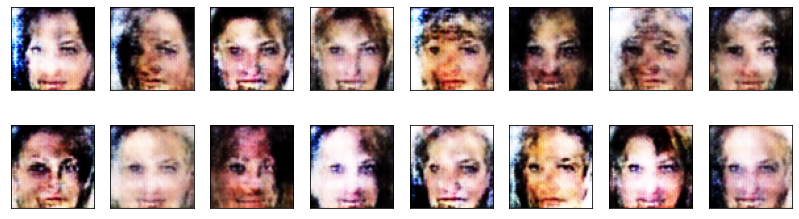

2023-02-12 12:57:15 | Epoch [18/20] | Batch 0/509 | d_loss: 0.0556 | g_loss: 9.8193
2023-02-12 12:57:17 | Epoch [18/20] | Batch 50/509 | d_loss: 0.0009 | g_loss: 15.0342
2023-02-12 12:57:18 | Epoch [18/20] | Batch 100/509 | d_loss: 0.0020 | g_loss: 10.8938
2023-02-12 12:57:20 | Epoch [18/20] | Batch 150/509 | d_loss: 0.0131 | g_loss: 8.1232
2023-02-12 12:57:21 | Epoch [18/20] | Batch 200/509 | d_loss: 0.0116 | g_loss: 8.7601
2023-02-12 12:57:23 | Epoch [18/20] | Batch 250/509 | d_loss: 0.0002 | g_loss: 6.1221
2023-02-12 12:57:25 | Epoch [18/20] | Batch 300/509 | d_loss: 0.0068 | g_loss: 5.7563
2023-02-12 12:57:26 | Epoch [18/20] | Batch 350/509 | d_loss: 0.0154 | g_loss: 11.1644
2023-02-12 12:57:28 | Epoch [18/20] | Batch 400/509 | d_loss: 0.0042 | g_loss: 11.4213
2023-02-12 12:57:29 | Epoch [18/20] | Batch 450/509 | d_loss: 0.5422 | g_loss: 9.4581
2023-02-12 12:57:31 | Epoch [18/20] | Batch 500/509 | d_loss: 0.0049 | g_loss: 10.5603


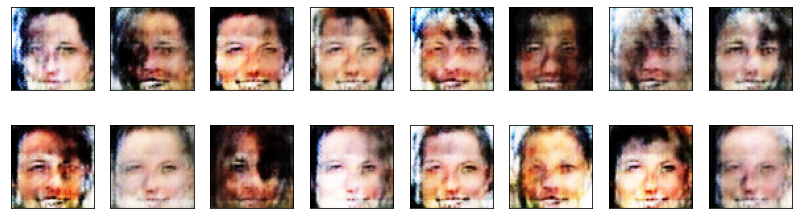

2023-02-12 12:57:32 | Epoch [19/20] | Batch 0/509 | d_loss: 0.0000 | g_loss: 16.7632
2023-02-12 12:57:34 | Epoch [19/20] | Batch 50/509 | d_loss: 0.0013 | g_loss: 14.6142
2023-02-12 12:57:35 | Epoch [19/20] | Batch 100/509 | d_loss: 0.0003 | g_loss: 13.3620
2023-02-12 12:57:37 | Epoch [19/20] | Batch 150/509 | d_loss: 0.0025 | g_loss: 11.5353
2023-02-12 12:57:38 | Epoch [19/20] | Batch 200/509 | d_loss: 0.0040 | g_loss: 3.4218
2023-02-12 12:57:40 | Epoch [19/20] | Batch 250/509 | d_loss: 0.3123 | g_loss: 9.0709
2023-02-12 12:57:42 | Epoch [19/20] | Batch 300/509 | d_loss: 0.0010 | g_loss: 12.8498
2023-02-12 12:57:43 | Epoch [19/20] | Batch 350/509 | d_loss: 0.3298 | g_loss: 9.0759
2023-02-12 12:57:45 | Epoch [19/20] | Batch 400/509 | d_loss: 0.0129 | g_loss: 10.1301
2023-02-12 12:57:46 | Epoch [19/20] | Batch 450/509 | d_loss: 0.0058 | g_loss: 5.6686
2023-02-12 12:57:48 | Epoch [19/20] | Batch 500/509 | d_loss: 0.0001 | g_loss: 5.9389


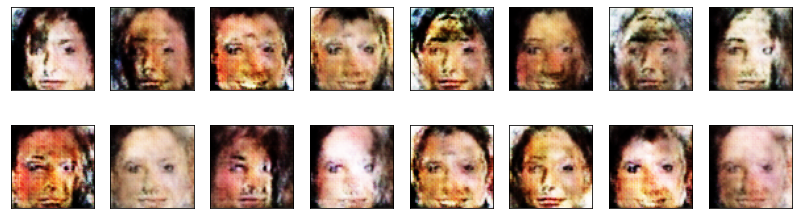

2023-02-12 12:57:49 | Epoch [20/20] | Batch 0/509 | d_loss: 0.0009 | g_loss: 13.4926
2023-02-12 12:57:51 | Epoch [20/20] | Batch 50/509 | d_loss: 0.0000 | g_loss: 18.6608
2023-02-12 12:57:52 | Epoch [20/20] | Batch 100/509 | d_loss: 1.8215 | g_loss: 9.1401
2023-02-12 12:57:54 | Epoch [20/20] | Batch 150/509 | d_loss: 0.0004 | g_loss: 16.0407
2023-02-12 12:57:56 | Epoch [20/20] | Batch 200/509 | d_loss: 0.0098 | g_loss: 9.8322
2023-02-12 12:57:57 | Epoch [20/20] | Batch 250/509 | d_loss: 0.0052 | g_loss: 4.6658
2023-02-12 12:57:59 | Epoch [20/20] | Batch 300/509 | d_loss: 0.0001 | g_loss: 17.0934
2023-02-12 12:58:01 | Epoch [20/20] | Batch 350/509 | d_loss: 0.0020 | g_loss: 3.0040
2023-02-12 12:58:02 | Epoch [20/20] | Batch 400/509 | d_loss: 0.6619 | g_loss: 7.7625
2023-02-12 12:58:04 | Epoch [20/20] | Batch 450/509 | d_loss: 0.0003 | g_loss: 8.4108
2023-02-12 12:58:05 | Epoch [20/20] | Batch 500/509 | d_loss: 0.0002 | g_loss: 13.3673


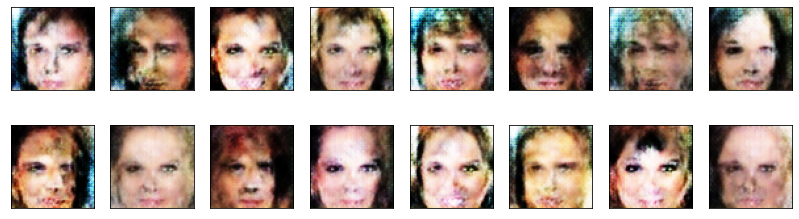

In [209]:
writer = SummaryWriter(f"runs/DCGAN_{datetime.now():%Y-%m-%d_%H-%M-%S}", 
                      comment=f"label_smoothing")

fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().to(device)

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################
        
        # TODO: implement the training strategy
        
        ####################################
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================

        d_loss = discriminator_step(discriminator, d_optimizer, batch_size, latent_dim, real_images)

        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================

        g_loss = generator_step(generator, discriminator, g_optimizer, batch_size, latent_dim)

        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
            writer.add_scalar('d_loss', d, epoch * len(dataloader) + batch_i)
            writer.add_scalar('g_loss', g, epoch * len(dataloader) + batch_i)
            
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)

    # save image for tensorboard
    grid = torchvision.utils.make_grid(torch.from_numpy(denormalize(generated_images.detach().cpu().numpy())))
    writer.add_image('images', grid, epoch)

    generator.train()

writer.close()

### Training losses

Plot the training losses for the generator and discriminator.

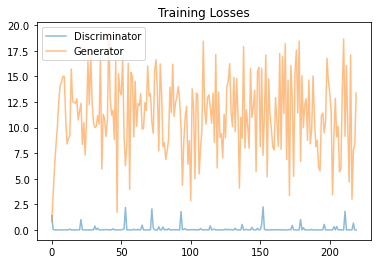

In [210]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.